In [1]:
# C:\dev2\AI_Agent\real_estate_tax_graph_jh.py
# C:\dev2\AI_Agent\income_tax_graph_jh.py

In [2]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    query: str
    answer: str
    context: list

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import Literal
from pydantic import BaseModel, Field

class Route(BaseModel):
    target: Literal["real_estate_tax", "llm", "income_tax"] = Field(description = """
    당신은 사용자의 질문을 보고 적절한 라우터를 연결해주는 전문가입니다.
    부동산에 관련된 질문은 real_estate_tax_graph라우터를, 소득세에 관한 질문은 income_tax라우터를, 그 외의 질문은 llm 라우터로 연결해주세요. 
    """)

def router(state: AgentState):
    query = state["query"]
    router_llm = llm.with_structured_output(Route)

    response = router_llm.invoke(query)

    return response.target

In [5]:
def basic_llm(state: AgentState):
    query = state["query"]
    response = llm.invoke(query)
    return {"answer": response}

In [7]:
from langgraph.graph import StateGraph, END, START

builder_graph = StateGraph(AgentState)

In [8]:
from income_tax_graph_jh import graph as income_tax_graph
from real_estate_tax_graph_jh import graph as real_estate_tax_graph

builder_graph.add_node("basic_llm", basic_llm)
builder_graph.add_node("income_tax_graph", income_tax_graph)
builder_graph.add_node("real_estate_tax_graph", real_estate_tax_graph)

c:\dev2\AI_Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\dev2\AI_Agent\real_estate_tax_graph_jh.py:109: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [ ]:
builder_graph.nodes

{'basic_llm': StateNodeSpec(runnable=basic_llm(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'income_tax_graph': StateNodeSpec(runnable=<langgraph.graph.state.CompiledStateGraph object at 0x0000022DABCA5910>, metadata=None, input_schema=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'real_estate_tax_graph': StateNodeSpec(runnable=<langgraph.graph.state.CompiledStateGraph object at 0x0000022DABF2AE40>, metadata=None, input_schema=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [9]:
builder_graph.add_conditional_edges(START, router, 
{
    "llm": "basic_llm",
    "real_estate_tax": "real_estate_tax_graph",
    "income_tax": "income_tax_graph"
    })

builder_graph.add_edge("basic_llm", END)
builder_graph.add_edge("income_tax_graph", END)
builder_graph.add_edge("real_estate_tax_graph", END)

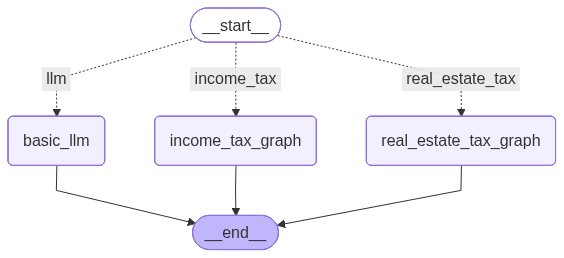

In [10]:
builder_graph.compile()

In [11]:
graph = builder_graph.compile()

In [12]:
initial_state = {"query": "소득세란 무엇인가요?"}
graph.invoke(initial_state)

{'query': '소득세란 무엇인가요?',
 'answer': '소득세는 개인의 소득에 대해 소득의 성격과 납세자의 부담 능력 등을 고려하여 과세하는 세금으로, 세부담의 형평성과 재정수입의 원활한 조달을 목적으로 합니다. 소득의 종류에는 이자소득, 배당소득, 사업소득, 근로소득, 연금소득 및 기타 소득 등이 포함됩니다. 거주자와 비거주자의 소득에 따라 과세 규정이 다르게 적용됩니다.',
 'context': [Document(id='dca8256b-c014-4be5-a128-c5c8d28993d6', metadata={'source': 'C:\\dev2\\AI_Agent\\수업\\LangGraph를 활용한 AI Agent 개발(feat.MCP)\\Practice\\output_test\\income_tax.txt'}, page_content='소득세법\n[시행 2025. 1. 1.] [법률 제20615호, 2024. 12. 31., 일부개정]\n기획재정부 (세제개편과(소득세)) 044-215-4312\n기획재정부 (소득세세제과(법인세)) 044-215-4216\n기획재정부 (음식세제과(아이슨소득)) 044-215-4233\n기획재정부 (소득세제과(사업소득, 기타소득)) 044-215-4217\n제1장 총칙\n제1조(목적)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[종전 제1조는 제2조로 이동 <2009. 12. 31.>]\n제2조(정의)\n① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27., 2014. 12. 23., 2018. 12. 31.>\n1. "거주자"란 국내에 주소를 두거나 183일 이상 거소(居所)를 둔 개인을 말한다.\n2. "비거주자"란 거주자가 아닌 개인을 말한다.\n3. "국내법인"이란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n4

In [13]:
initial_state = {"query": "집 15억은 세금을 얼마나 내나요?"}

graph.invoke(initial_state)

{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '주택의 공시가격이 15억 원이고, 사용자가 소지한 주택 수에 따라 종합부동산세를 계산해보겠습니다. 갑의 경우를 고려해보겠습니다.\n\n### 1. 만약 사용자가 1세대 1주택자인 경우:\n\n- 과세표준: 1.8억 원\n  - 세율: 1천분의 5\n  - 종합부동산세 = 1.8억 원 × 0.5% = 90만 원\n\n### 2. 만약 사용자가 법인이나 법인으로 간주되는 단체인 경우:\n\n- 과세표준: 5.4억 원\n  - 주택 수에 관계없이 1천분의 27\n  - 종합부동산세 = 5.4억 원 × 2.7% = 1,458만 원\n\n### 3. 그 외의 경우(예: 다주택자):\n\n- 과세표준: 3.6억 원\n  - 세율:\n    - 3억 원 초과 6억 원 이하: 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)\n  - 추가 금액 = (3.6억 원 - 3억 원) × 0.7% = 0.6억 원 × 0.7% = 42만 원\n  - 종합부동산세 = 150만 원 + 42만 원 = 192만 원\n\n이러한 경우 중 사용자가 해당되는 항목에 따라 종합부동산세가 배정됩니다. gereken durumuna göre kullanıcı kendisi için uygun olan sonucu hesaplamalıdır.'}

In [ ]:
initial_state = {"query": "떡볶이는 어디가 맛있나요?"}
graph.invoke(initial_state)